# Telecom Churn Identification Project

## Preliminary Modeling and Grid Search

This file uses grid search cross validation on each of the following models to find the best parameters for each.  Models tested are:<br>
<ul>
    <li>Logistic Regression</li>
    <li>K Nearest Neighbors</li>
    <li>Random Forest</li>
    <li>Support Vector Classifier</li>
    <li>Naive Bayes</li>
</ul><br>
I then compare common metrics for each of the models for use in final model evaluation.


----

#### Import the tools we need

----

In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go

sys.path.append('/Users/maboals/Documents/Work/Programming/PyStuff/MyTools/src')
from MLModelingTools import model_test, model_testN

sys.path.append('../src')
from my_eval_tools import calc_roc_data
from my_eval_tools import calc_hybrid_roc_data 
from my_eval_tools import hybrid_predict, hybrid_predict_proba
from my_eval_tools import calc_pr_sweep
from my_eval_tools import predict_sweep


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

Using TensorFlow backend.


----

## Training Data


----

Read the training data file.  This file was created by running the notebooks:
* Telecom to SQL
* Telecom clean and eda

In [3]:
# Read the csv file save by the clean/eda notebook
train_df = pd.read_csv('../data/churn_train_clean.csv')


# Sometimes the index column is read as an unnamed column, if so drop it
if 'Unnamed: 0' in train_df.columns :
    train_df = train_df.drop('Unnamed: 0', axis=1)
    
train_df.columns = ['customerID', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'Month-to-month', 'One year', 'DSL', 'Fiber optic', 'Female']

In [4]:
# Define which columns we're going to use in our modeling.
train_columns1 = ['SeniorCitizen', 'Partner', 'Dependents', \
       'Tenure',   \
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', \
       'StreamingTV', 'StreamingMovies', 'MonthlyCharges', 'TotalCharges', \
       'Month-to-month', 'Fiber optic'] #, 'One year', 'Female']

train_columns2 = ['tenure', 'OnlineSecurity', 'Month-to-month', 'Fiber optic', 'MonthlyCharges']

train_columns = train_columns1

X = train_df[train_columns]
y= train_df['Churn']

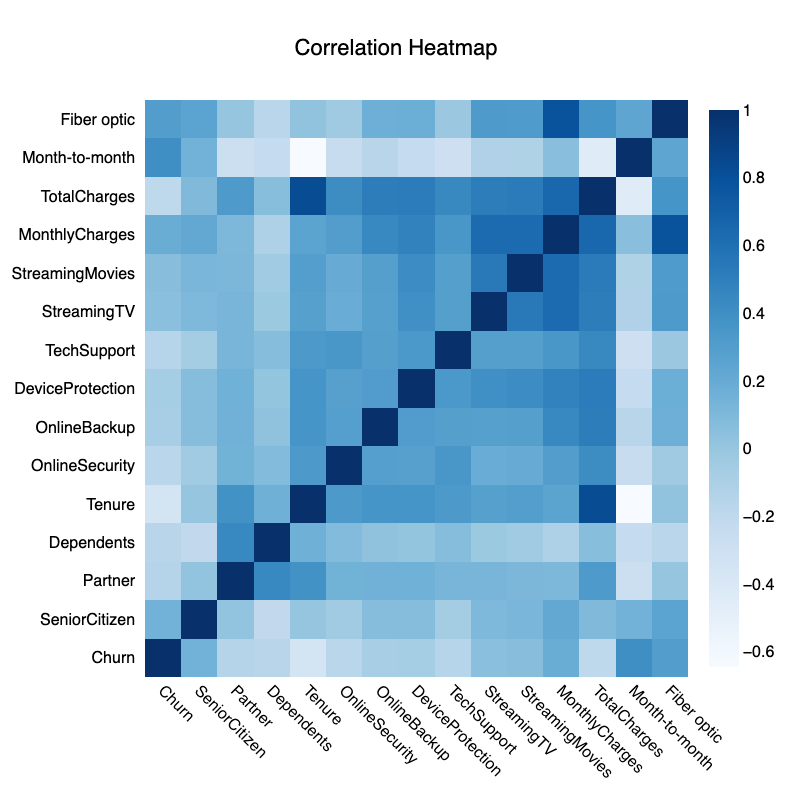

'\nfig.patch.set_alpha(0.)\nsns.set(font_scale=1.5)\ng = sns.heatmap(data=corr, cmap = "Blues")\ng.set_xticklabels(corr.columns, fontsize = 16)\ng.set_yticklabels(corr.columns, fontsize = 16)\n\n#sns.heatmap(corr, cmap=\'Blues\', )\nplt.title(\'Feature Correlation Heat Map\n\', size=30)\nplt.savefig(\'feature_heatmap.png\', Transparent=True)\n'

<Figure size 864x576 with 0 Axes>

In [10]:
corr = train_df[['Churn']+train_columns].corr()
corr.columns = [corr.columns[x]+'  ' for x in range(len(corr.columns))]
fig = plt.figure(figsize=[12,8])

layout = go.Layout(paper_bgcolor = 'rgba(0,0,0,0)',
            plot_bgcolor = 'rgba(0,0,0,0)',
            width=800, height=800)

fig = go.Figure(data=go.Heatmap(
                z=corr,
                x=corr.columns,
                y=corr.columns,
                colorscale='Blues',
                hoverongaps = False),
                layout=layout)

fig.update_layout(
    title={
        'text': "Correlation Heatmap",
        'x': 0.5, 'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'},
    
        font=dict(
            family="Helvetica",
            size=16,
            color="black"
        ),
    xaxis = { 'tickangle' : 45})
                    
fig.show(render='png')

'''
fig.patch.set_alpha(0.)
sns.set(font_scale=1.5)
g = sns.heatmap(data=corr, cmap = "Blues")
g.set_xticklabels(corr.columns, fontsize = 16)
g.set_yticklabels(corr.columns, fontsize = 16)

#sns.heatmap(corr, cmap='Blues', )
plt.title('Feature Correlation Heat Map\n', size=30)
plt.savefig('feature_heatmap.png', Transparent=True)
'''

### Train, test split

Make a training data subset and a validation data subset

Then make a balanced training dataset using smote

In [6]:
# Split the original dataset into train and validation groups
#  set stratify to true so both classes are represented it the splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Make a balance set for model training
sm = SMOTE(random_state=42)
X_train_smt, y_train_smt = sm.fit_resample(X_train, y_train)

----

### Baseline with Logistic Regression

Start with a logistic regression model.

Make a process pipeline to use the grid search cross validation tool

In [30]:
sm = SMOTE(random_state=42)
log_model = LogisticRegression()
steps = [('smt', sm), ('LOG', log_model)]

pipeline = Pipeline(steps) # define the pipeline object.

In [31]:
log_param_grid = {
    'smt__random_state': [45],
    'LOG__solver': ['liblinear'],
    'LOG__C' : [0.001, 0.01, 0.02, 0.03, 0.07, 0.1, 0.5, 0.75, 1, 1.5, 3, 10, 20],
    'LOG__penalty' : ['l1', 'l2']
}

In [32]:
log_grid = GridSearchCV(pipeline, param_grid=log_param_grid, scoring='f1', cv=5, n_jobs=-1)

In [33]:
log_grid.fit(X_train_smt, y_train_smt)
print("score = %3.2f" %(log_grid.score(X_test,y_test)))
print(log_grid.best_params_)

score = 0.61
{'LOG__C': 20, 'LOG__penalty': 'l2', 'LOG__solver': 'liblinear', 'smt__random_state': 45}


----

### KNN Model

Build the pipeline for the cross validation and set the parameters to be scanned.


In [34]:
from imblearn.pipeline import Pipeline
sm = SMOTE(random_state=42)
knn = KNeighborsClassifier()
steps = [('smt', sm), ('KNN', knn)]

pipeline = Pipeline(steps) # define the pipeline object.

Set the parameters for the pipeline steps

In [35]:
knn_param_grid = {
    'smt__random_state': [45],
    'KNN__n_neighbors': [2, 4, 6, 8, 10],
}


Use grid search to find the optimum parameters for the Knn model

In [36]:
knn_grid = GridSearchCV(pipeline, param_grid=knn_param_grid, scoring='f1', cv=5, n_jobs=-1)

In [37]:
knn_grid.fit(X_train_smt, y_train_smt)
print("score = %3.2f" %(knn_grid.score(X_test,y_test)))
print(knn_grid.best_params_)

score = 0.55
{'KNN__n_neighbors': 6, 'smt__random_state': 45}


----

## Random Forest Classifier

Build the pipeline and search parameter grid for random forest

In [38]:
sm = SMOTE(random_state=42)
rf = RandomForestClassifier()
steps = [('smt', sm), ('RFC', rf)]

rf_pipeline = Pipeline(steps) # define the pipeline object.

In [39]:
rf_param_grid = {
    'smt__random_state': [10],
    'RFC__n_estimators': [50, 100, 150, 200, 1000],
    'RFC__max_depth' : [2,3,4],
    'RFC__max_features' : [5, 10, 15],
    'RFC__criterion' : ['gini', 'entropy'],
    'RFC__random_state' :[42]
}

In [40]:
rf_grid = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, scoring='f1', cv=5, n_jobs=-1)

In [41]:
rf_grid.fit(X_train_smt, y_train_smt)
print("score = %3.2f" %(rf_grid.score(X_test,y_test)))
print(rf_grid.best_params_)

score = 0.60
{'RFC__criterion': 'gini', 'RFC__max_depth': 4, 'RFC__max_features': 5, 'RFC__n_estimators': 1000, 'RFC__random_state': 42, 'smt__random_state': 10}


#### With Random Forest we can get a rating of relative feature importance.

In [42]:
rf_best = RandomForestClassifier(max_depth=2, max_features=10, \
                n_estimators=1000, criterion='entropy', random_state=42)
rf_best.fit(X_train_smt, y_train_smt)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [43]:
rf_importances = rf_best.feature_importances_
rf_importances

array([0.00000000e+00, 1.45077393e-04, 3.50849366e-04, 1.43674115e-01,
       4.00076106e-02, 0.00000000e+00, 0.00000000e+00, 1.61669088e-03,
       0.00000000e+00, 5.48413428e-04, 5.90411752e-02, 8.07773354e-03,
       6.08058857e-01, 1.38479478e-01])

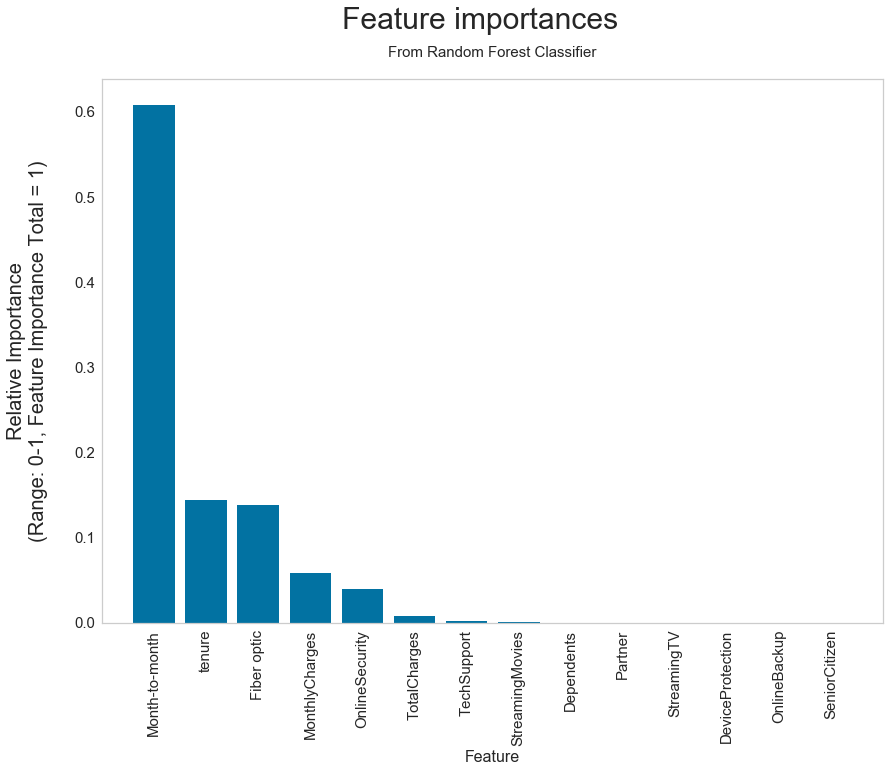

In [45]:
# Plot the feature importances of the forest
indices = np.argsort(rf_importances)[::-1]
index_labels = [X_train.columns[x] for x in indices]

fig = plt.figure(figsize=[14,10])

fig.patch.set_alpha(0.)

plt.grid(0)
plt.suptitle("Feature importances\n", size=30)
plt.title("\nFrom Random Forest Classifier\n", size=15)
plt.xlabel('Feature', size=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Relative Importance\n(Range: 0-1, Feature Importance Total = 1)\n', size=20)
plt.bar(range(X_train.shape[1]), rf_importances[indices],
       color="b", align="center")
plt.xticks(range(X_train.shape[1]), labels=index_labels, rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('FeatureImportances.png', Transparent=True)
plt.show()


----

### Support Vector Classifier

Build the pipeline for SVC and define the parameters to search

In [26]:
svc = SVC(probability=True)

steps = [('smt', sm), ('SVC', svc)]

svc_pipeline = Pipeline(steps) # define the pipeline object.

In [27]:
svc_param_grid = {
    'smt__random_state': [10],
    'SVC__kernel': ['linear', 'rbf'],
    'SVC__C' : [0.5, 1, 1.5],
    'SVC__random_state' :[42]
}

In [28]:
svc_grid = GridSearchCV(svc_pipeline, param_grid=svc_param_grid, scoring='f1', cv=5, n_jobs=-1)

In [29]:
svc_grid.fit(X_train, y_train)
print("score = %3.2f" %(svc_grid.score(X_test,y_test)))
print(svc_grid.best_params_)

/Users/maboals/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


score = 0.63
{'SVC__C': 1.5, 'SVC__kernel': 'rbf', 'SVC__random_state': 42, 'smt__random_state': 10}


----

### Naive Bayes

Configure the grid search for Naive Bayes

In [31]:
nb = GaussianNB()
# define the pipeline object.

steps = [('smt', sm), ('NB', nb)]

pipeline = Pipeline(steps) # define the pipeline object.

In [32]:
nb_param_grid = {
    'smt__random_state': [45],
    'NB__var_smoothing': [0.0, 0.5, 1.0, 1.5, 10, 20, 50]

}

In [33]:
nb_grid = GridSearchCV(pipeline, param_grid=nb_param_grid, scoring='f1', cv=5, n_jobs=-1)

In [34]:
nb_grid.fit(X_train, y_train)
print("score = %3.2f" %(nb_grid.score(X_test,y_test)))
print(nb_grid.best_params_)

score = 0.59
{'NB__var_smoothing': 0.0, 'smt__random_state': 45}


In [35]:
'''
recall
score = 0.78
{'NB__var_smoothing': 20, 'smt__random_state': 45}
'''

"\nrecall\nscore = 0.78\n{'NB__var_smoothing': 20, 'smt__random_state': 45}\n"